In [1]:
library(tidyverse)
library(DESeq2)
library(BiocParallel)
library(pheatmap)
library(RColorBrewer)
library(umap)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.0
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects

In [2]:
set.seed(10)
projects <- c("TCGA-CESC", "TCGA-OV", "TCGA-UCS", "TCGA-UCEC")
data_root <- "../../../../../mnt/d/TCGA"
count_files <- Sys.glob(paths = paste0(data_root, "/", "tumor_only_matrix_data", "/*counts.tsv"))
coldata_files <- Sys.glob(paths = paste0(data_root, "/", "tumor_only_matrix_data", "/*coldata.tsv"))

In [3]:
n_cores <- detectCores() - 2
BiocParallel::register(MulticoreParam(n_cores))

In [4]:
count_files
coldata_files

[1] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_CESC_counts.tsv"
[2] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_OV_counts.tsv"  
[3] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_UCEC_counts.tsv"
[4] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_UCS_counts.tsv"

[1] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_CESC_coldata.tsv"
[2] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_OV_coldata.tsv"  
[3] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_UCEC_coldata.tsv"
[4] "../../../../../mnt/d/TCGA/tumor_only_matrix_data/TCGA_UCS_coldata.tsv"

In [5]:
count_df_ls <- map(.x = count_files, .f = read_tsv)
coldata_df_ls <- map(.x = coldata_files, .f = read_tsv)

Parsed with column specification:
cols(
  .default = col_double(),
  hgnc_symbol = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  hgnc_symbol = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  hgnc_symbol = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  .default = col_double(),
  hgnc_symbol = col_character()
)
See spec(...) for full column specifications.
Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)
Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)
Parsed with column specification:
cols(
  sample_name = col_character(),
  condition = col_character(),
  project = col_character()
)
Parsed wit

# Functions

In [6]:
combine_data <- function(coldata_df_ls, count_df_ls) {
    coldata_df <- bind_rows(coldata_df_ls) %>%
        column_to_rownames(var = "sample_name")
    count_df <- purrr::reduce(count_df_ls, inner_join, by = "hgnc_symbol") %>%
        column_to_rownames(var = "hgnc_symbol")
    return(list(coldata_df, count_df))
}


data_sample_n <- function(coldata_df_ls, count_df_ls, n) {
    coldata_samp_ls <- list()
    count_samp_ls <- list()
    for (i in seq_len(length(count_df_ls))) {
        coldata_samp <- dplyr::sample_n(coldata_df_ls[[i]], size = n, replace = FALSE)
        count_samp <- dplyr::select(count_df_ls[[i]], hgnc_symbol, coldata_samp$sample_name)
        coldata_samp_ls[[i]] <- coldata_samp
        count_samp_ls[[i]] <- count_samp
    }
    return(combine_data(coldata_samp_ls, count_samp_ls))
}


pca_scatter <- function(df, pc_x, pc_y, col) {
    plt <- ggplot(df) +
        aes_string(x = pc_x, y = pc_y, color = col) +
        geom_point(size=1) +
        xlab(paste0(pc_x)) + 
        ylab(paste0(pc_y)) +
        coord_fixed()
    return(plt)
}

# Heatmaps

## Take *n* random samples from each dataset

In [7]:
res_ls <- data_sample_n(coldata_df_ls, count_df_ls, 10)
coldata_samp_df <- res_ls[[1]]
count_samp_df <- res_ls[[2]]

In [8]:
all(rownames(coldata_samp_df) == colnames(count_samp_df))

[1] TRUE

## Normalize counts

In [9]:
# rlog_count_samp <- rlog(as.matrix(count_samp_df), blind = FALSE)
vst_count_samp <- vst(as.matrix(count_samp_df), blind = FALSE)

converting counts to integer mode


In [10]:
vst_count_samp_df <- vst_count_samp %>%
    as_tibble() %>%
    mutate(hgnc_symbol = rownames(count_samp_df)) %>%
    select(hgnc_symbol, everything()) %>%
    column_to_rownames(var = "hgnc_symbol")

## Aggregate rows by within-project mean

In [11]:
CESC_mask <- coldata_samp_df$project == "TCGA_CESC"
OV_mask <- coldata_samp_df$project == "TCGA_OV"
UCEC_mask <- coldata_samp_df$project == "TCGA_UCEC"
UCS_mask <- coldata_samp_df$project == "TCGA_UCS"

In [12]:
vst_count_agg_df <- vst_count_samp_df %>%
    mutate(mean_CESC = rowMeans(dplyr::select(., which(CESC_mask)))) %>%
    mutate(mean_OV = rowMeans(dplyr::select(., which(OV_mask)))) %>%
    mutate(mean_UCEC = rowMeans(dplyr::select(., which(UCEC_mask)))) %>%
    mutate(mean_UCS = rowMeans(dplyr::select(., which(UCS_mask)))) %>%
    select(mean_CESC, mean_OV, mean_UCEC, mean_UCS)

In [13]:
head(vst_count_agg_df)

,mean_CESC,mean_OV,mean_UCEC,mean_UCS
,<dbl>,<dbl>,<dbl>,<dbl>
1,3.298373,4.010888,3.461187,3.277584
2,4.004363,4.227211,4.303639,4.176392
3,7.907985,12.503998,8.666688,7.623022
4,4.638237,4.822932,4.687128,5.362478
5,5.897021,5.556785,5.728114,6.603249
6,3.708283,3.676162,3.752884,4.277944


## Look at 1000 genes with highest inter-project variance

In [14]:
inter_proj_vars <- rowVars(as.matrix(vst_count_agg_df))

In [15]:
var_thresh <- inter_proj_vars[order(inter_proj_vars, decreasing = TRUE)][1000]

In [16]:
var_thresh

[1] 2.504688

In [17]:
ip_var_mask <- inter_proj_vars >= var_thresh

In [18]:
vst_high_var_df <- vst_count_samp_df %>%
    rownames_to_column("hgnc_symbol") %>%
    mutate(var_mask = ip_var_mask) %>%
    dplyr::filter(var_mask == TRUE) %>%
    select(-var_mask) %>%
    column_to_rownames(var = "hgnc_symbol")
head(vst_high_var_df)

,TCGA-C5-A3HL-01A-11R-A213-07,TCGA-EA-A44S-01A-12R-A26T-07,TCGA-EK-A2IR-01A-11R-A180-07,TCGA-EK-A2PL-01A-11R-A18M-07,TCGA-VS-A958-01A-11R-A42T-07,TCGA-EK-A2RA-01A-11R-A18M-07,TCGA-EK-A2RJ-01A-11R-A18M-07,TCGA-C5-A1M7-01A-11R-A13Y-07,TCGA-C5-A1M8-01A-21R-A13Y-07,TCGA-VS-A8QF-01A-21R-A37O-07,⋯,TCGA-N5-A4RV-01A-21R-A28V-07,TCGA-N6-A4VC-01A-11R-A28V-07,TCGA-N8-A4PI-01A-21R-A28V-07,TCGA-NA-A4QX-01A-11R-A28V-07,TCGA-NF-A4WX-01A-11R-A28V-07,TCGA-NF-A5CP-01A-12R-A28V-07,TCGA-N8-A4PP-01A-11R-A28V-07,TCGA-N6-A4VF-01A-31R-A28V-07,TCGA-QN-A5NN-01A-11R-A28V-07,TCGA-NA-A4R1-01A-11R-A28V-07
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
7SK,6.974948,7.923671,8.148325,5.924735,6.061051,11.571051,8.528091,8.072120,9.336673,6.539190,⋯,8.930741,7.307324,7.720446,7.310299,7.680580,6.662541,8.404649,8.430518,6.414662,7.368461
A2ML1,14.591547,14.184454,6.473054,12.847158,12.714488,9.629887,14.099545,13.035023,13.327162,13.442961,⋯,4.700271,5.585809,5.303005,4.912556,8.264483,6.722645,6.782747,5.990664,9.064349,4.280521
AARD,3.622628,3.642651,5.441303,3.196081,3.776961,3.196081,4.053744,3.958911,3.196081,3.196081,⋯,6.137869,6.325117,3.904204,6.979394,8.425587,7.893278,6.751890,6.497352,9.306244,9.184010
ABCA12,9.954583,10.393482,9.748835,9.941361,10.916103,10.139410,9.955690,11.738270,10.695846,10.671454,⋯,5.383605,6.422826,4.334330,5.145385,5.430620,5.328511,5.068824,6.030802,4.682469,4.363102
AC007405.6,5.535319,3.963572,4.355394,3.975069,3.196081,6.888699,5.829797,4.437247,4.791522,4.841838,⋯,8.556674,7.766387,7.176378,7.234467,6.733105,7.084482,7.586274,7.882194,6.585577,8.039540
AC010970.2,3.196081,4.426580,5.341161,4.703534,3.196081,10.168951,4.935149,6.092491,8.643288,3.675479,⋯,3.717654,3.838916,3.196081,3.798209,3.659865,4.251834,3.613122,4.176110,4.160246,3.647455


In [19]:
col_dist <- as.dist(1 - cor(vst_high_var_df, method = "spearman"))
row_dist <- as.dist(1 - cor(t(vst_high_var_df), method = "pearson"))

col_clust <- hclust(col_dist, method = "complete")
row_clust <- hclust(row_dist, method = "complete")

In [20]:
calc_z_score <- function(x){
  (x - mean(x)) / sd(x)
}

In [21]:
# call to apply() transposes rowwise results, so must perform transpose again
z_score_mat <- t(apply(vst_high_var_df, 1, calc_z_score))

In [22]:
proj_colors <- list(project = brewer.pal(n = 4, name = "Set1"))
names(proj_colors$project) <- unique(coldata_samp_df$project)

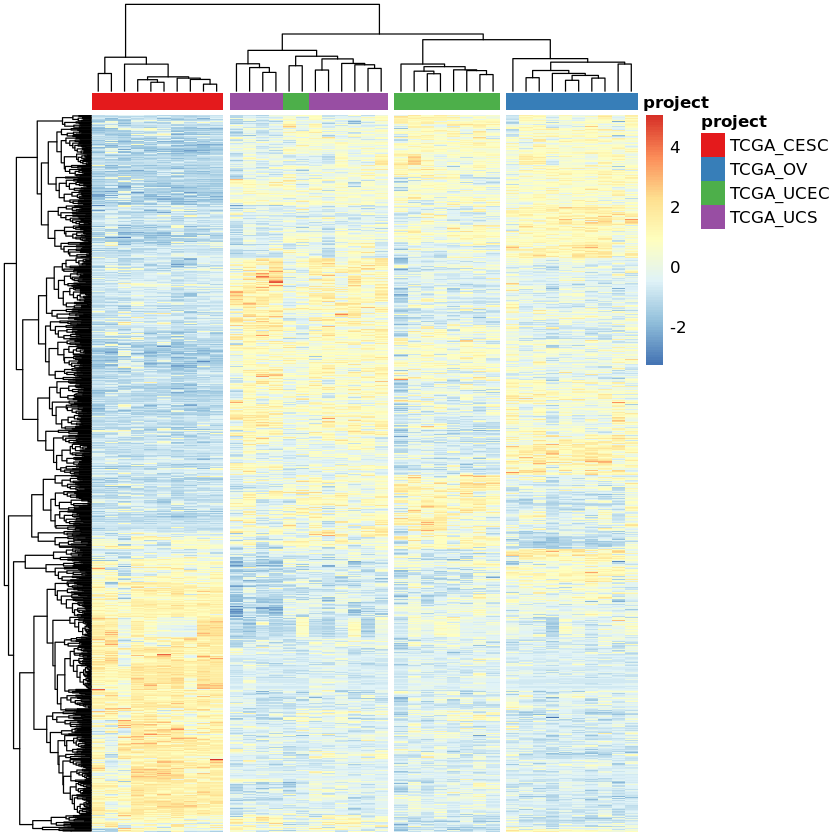

In [23]:
hm <- pheatmap(z_score_mat, cluster_rows = row_clust, cluster_cols = col_clust, cutree_cols = 4, annotation_col = coldata_samp_df["project"], annotation_colors = proj_colors, show_rownames = FALSE, show_colnames = FALSE)

In [24]:
png(paste(data_root, "figures", "heatmap_demo.png", sep = "/"))
grid::grid.newpage()
grid::grid.draw(hm$gtable)
dev.off()

png 
  2

# PCA

## Use & normalize full dataset

In [25]:
full_res_ls <- combine_data(coldata_df_ls, count_df_ls)
full_coldata_df <- full_res_ls[[1]]
full_count_df <- full_res_ls[[2]]

In [26]:
vst_full_count <- vst(as.matrix(full_count_df), blind = FALSE)

converting counts to integer mode


In [27]:
pca_res <- prcomp(t(vst_full_count), center = TRUE, scale. = FALSE)

In [28]:
pca_res_df <- pca_res$x %>%
    as_tibble(rownames = "sample_name") %>%
    mutate(project = full_coldata_df$project)

In [29]:
pca_var <- pca_res$sdev ^ 2
pca_perc <- round(pca_var / sum(pca_var) * 100, 3)

In [30]:
pca_var_df <- tibble(pc = colnames(pca_res$x), var = pca_var, perc_var = pca_perc) %>%
    mutate(pc_fact = factor(colnames(pca_res$x), levels = colnames(pca_res$x)))

Saving 6.67 x 6.67 in image


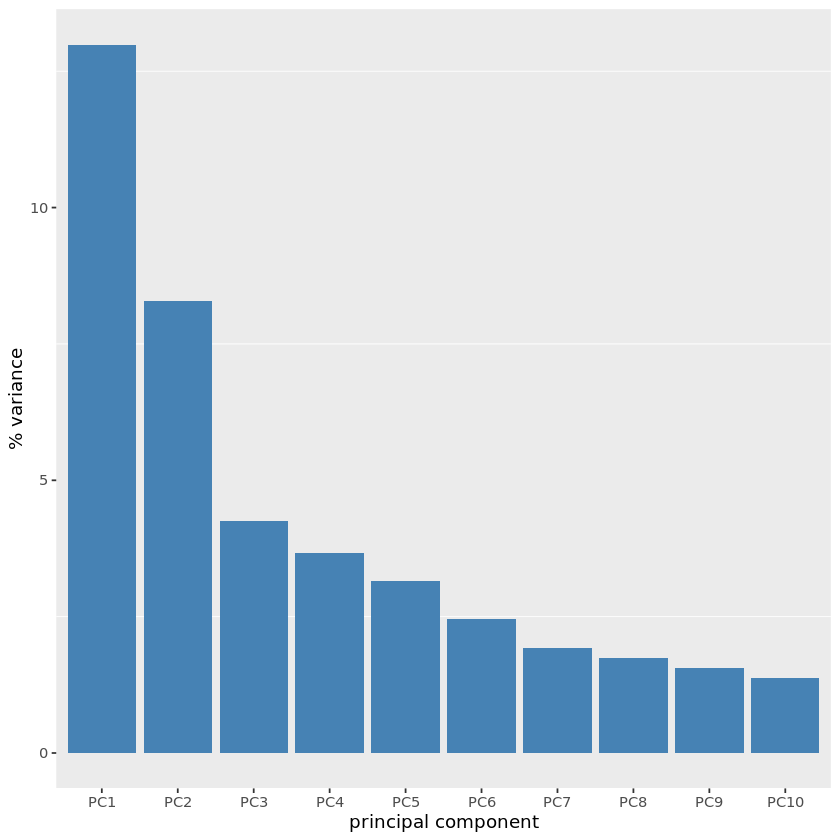

In [31]:
ggplot(data=pca_var_df[1:10, ], aes(x=pc_fact, y=perc_var)) +
    geom_bar(stat="identity", fill="steelblue") +
    xlab(label = "principal component") +
    ylab(label = "% variance") +
    theme(panel.grid.major = element_blank())
ggsave(filename = paste(data_root, "figures", "screeplot.png", sep = "/"))

Saving 6.67 x 6.67 in image


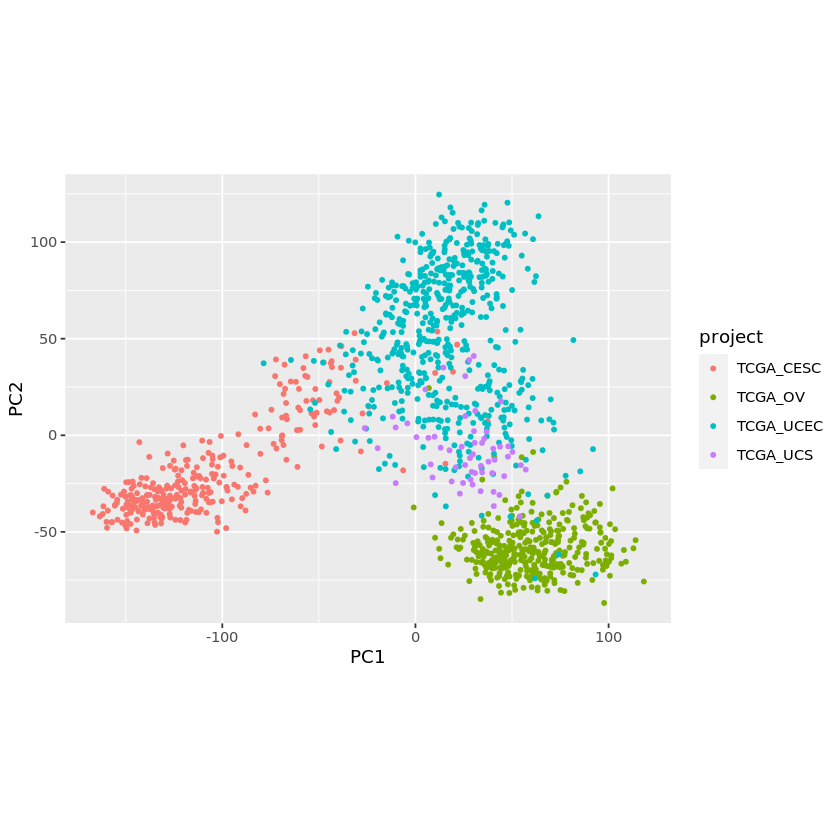

Saving 6.67 x 6.67 in image


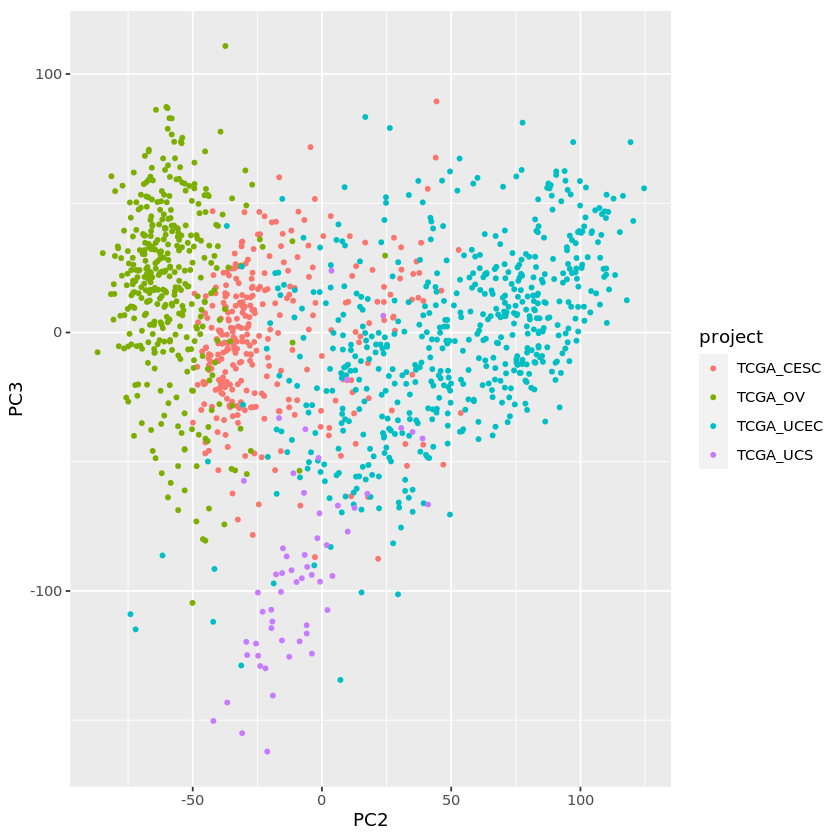

In [32]:
pca_scatter(pca_res_df, "PC1", "PC2", "project")
ggsave(filename = paste(data_root, "figures", "PC2_vs_PC1.png", sep = "/"), last_plot())
pca_scatter(pca_res_df, "PC2", "PC3", "project")
ggsave(filename = paste(data_root, "figures", "PC3_vs_PC2.png", sep = "/"), last_plot())

In [33]:
pca_pivot_df <- pca_res_df%>%
    select(sample_name, PC1:PC4, project) %>%
    pivot_longer(cols = PC1:PC4, names_to = "PC", values_to = "loadings")

In [34]:
head(pca_pivot_df)

sample_name,project,PC,loadings
<chr>,<chr>,<chr>,<dbl>
TCGA-JX-A3Q8-01A-11R-A21T-07,TCGA_CESC,PC1,-57.07940
TCGA-JX-A3Q8-01A-11R-A21T-07,TCGA_CESC,PC2,30.76374
TCGA-JX-A3Q8-01A-11R-A21T-07,TCGA_CESC,PC3,24.32452
TCGA-JX-A3Q8-01A-11R-A21T-07,TCGA_CESC,PC4,-38.01467
TCGA-C5-A1BK-01B-11R-A13Y-07,TCGA_CESC,PC1,-144.13636
TCGA-C5-A1BK-01B-11R-A13Y-07,TCGA_CESC,PC2,-29.98688


Saving 6.67 x 6.67 in image


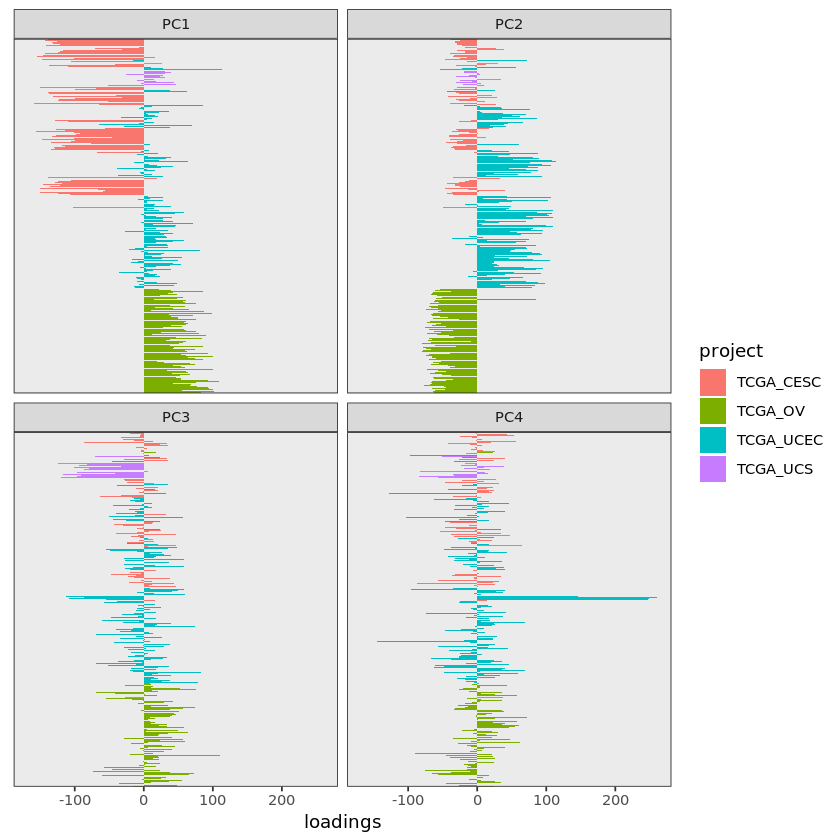

In [35]:
ggplot(pca_pivot_df) +
    aes(x=sample_name, y=loadings, fill=project) +
    geom_bar(stat="identity") +
    facet_wrap(~PC) +
    coord_flip() +
    theme_bw() + 
    theme(
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        axis.title.y = element_blank()
    )
ggsave(filename = paste(data_root, "figures", "small_multiples_plot.png", sep = "/"), plot = last_plot())

In [36]:
X <- t(full_count_df) %>%
    as_tibble()
Y <- cbind(colnames(full_count_df), full_coldata_df$project)
colnames(Y) <- c("sample_name", "project")
Y <- Y %>%
    as_tibble()

In [37]:
head(X)

5_8S_rRNA,5S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,⋯,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11AP1,ZYG11B,ZYX,ZYXP1,ZZEF1,ZZZ3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,1,209,5,65,0,9695,14,12,0,⋯,138,825,2308,1152,0,1991,8011,0,1735,2242
0,8,427,7,56,5,12350,15,4732,0,⋯,101,497,2190,70,0,1197,16036,0,2608,2263
0,7,112,14,89,1,3302,35,1821,0,⋯,206,791,2222,113,0,2240,3470,0,2082,2770
0,5,3556,4,16,0,4440,23,40544,1,⋯,198,744,2049,108,0,2461,8921,0,1529,2025
0,7,121,13,57,3,12461,13,64970,0,⋯,83,320,3153,46,0,1298,8289,0,3410,1426
0,4,2859,5,5,0,6966,13,2673,0,⋯,25,213,808,184,0,491,15505,0,739,796


In [38]:
res_umap <- umap(X)

In [39]:
colnames(res_umap$layout) <- c("x1", "x2")
umap_df <- res_umap$layout %>%
    as_tibble() %>%
    bind_cols(Y)
head(umap_df)

x1,x2,sample_name,project
<dbl>,<dbl>,<chr>,<chr>
0.121008,0.8565195,TCGA-JX-A3Q8-01A-11R-A21T-07,TCGA_CESC
2.748266,5.0305213,TCGA-C5-A1BK-01B-11R-A13Y-07,TCGA_CESC
1.856414,3.3791795,TCGA-Q1-A73Q-01A-21R-A32P-07,TCGA_CESC
2.699057,4.5529215,TCGA-C5-A8YQ-01A-11R-A37O-07,TCGA_CESC
3.249026,4.2846677,TCGA-VS-A9UC-01A-11R-A42T-07,TCGA_CESC
-1.131598,1.2088281,TCGA-C5-A1MF-01A-11R-A13Y-07,TCGA_CESC


Saving 6.67 x 6.67 in image


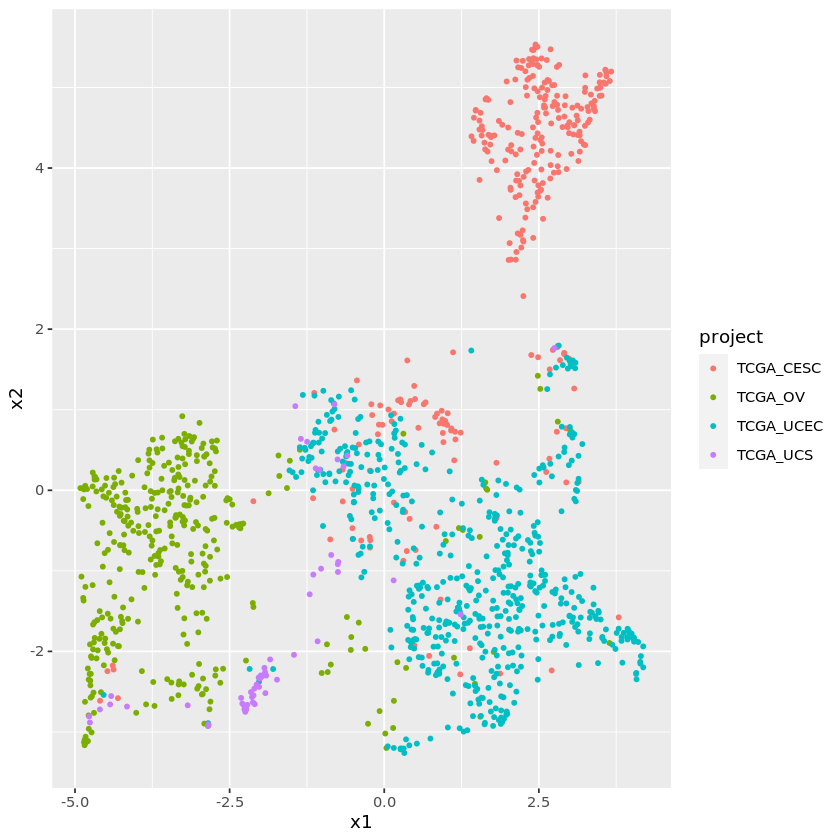

In [40]:
ggplot(umap_df) +
    aes(x = x1, y = x2, color = project) +
    geom_point(size=1)

ggsave(filename = paste(data_root, "figures", "umap.png", sep = "/"), plot = last_plot())